# RNNs

In the [last lesson](https://github.com/VikParuchuri/zero_to_gpt/blob/master/explanations/classification.ipynb), we learned how to use a neural network to transform an input into a classification.

In this lesson, we'll learn how to use neural networks to take in sequences of input and make predictions.  A sequence of input can be a sentence of words, or a series of weather observations.

Here is a sequence of temperatures:

In [6]:
import pandas as pd
import numpy as np

# Read in our data, and fill missing values
data = pd.read_csv("../data/clean_weather.csv", index_col=0)
data = data.ffill()

# Display a sequence of temperatures
data["tmax"].head(10)

1970-01-01    60.0
1970-01-02    52.0
1970-01-03    52.0
1970-01-04    53.0
1970-01-05    52.0
1970-01-06    50.0
1970-01-07    52.0
1970-01-08    56.0
1970-01-09    54.0
1970-01-10    57.0
Name: tmax, dtype: float64

With a normal neural network, you have to treat each element in a sequence as a separate neural network input, like this:

In [8]:
# Turn our sequence into a single row of data
data["tmax"].head(10).to_numpy()[np.newaxis,:]

array([[60., 52., 52., 53., 52., 50., 52., 56., 54., 57.]])

We could feed the above sequence as a single training example into a neural network.  But what if we don't know the length of the sequence beforehand?  For example, what if we wanted the neural network to predict the next word that came after a prompt?

We could have prompts with different lengths, like:

- `Write me a song`
- `Tell me a story about dinosaurs`
- `Add 1 and 2`

We want our network to be able to handle all of these inputs, even though they have different lengths.  One way to do this is to add extra zeros to the end of the sequence.

But this still introduces the issue that the neural network will have to learn parameters for each position separately.  For example, if we're passing in two weather observations of different lengths:

In [9]:
data["tmax"].head(6).to_numpy()[np.newaxis,:]

array([[60., 52., 52., 53., 52., 50.]])

In [10]:
data["tmax"].tail(10).to_numpy()[np.newaxis,:]

array([[64., 63., 62., 61., 60., 62., 67., 66., 70., 62.]])

We will need as many parameters in the network as the largest length of sequence we want to pass in.  This means that the network will be inefficient to train.

RNNs are neural networks that process entire sequences of input at once.  In this lesson, we'll learn how to build one in Python.

Parameter sharing

Rnns share parameters across sequence position.  Input weight, hidden weight, output weight

## RNN Architecture

RNNs work by sharing parameters (weights and biases) across steps in a sequence.  At a very high level, a recurrent neural network looks like this:

![Rolled RNN](images/rnn/rnn_rolled.svg)

What we see above is called a compact representation of an RNN.  We pass input into the bottom of an RNN.  It is then passed through the input step (I) and the hidden step (H) before getting to the output step (O) where you get a prediction for the next element in the sequence.

The arrow connecting H to itself is called recurrence.  It means that the H layers are connected to each other across sequence steps.  To see how this works, let's take a look at an expanded representation of an RNN:

![Unrolled RNN](images/rnn/rnn_unrolled.svg)

Each sequence element is labeled at the bottom with the index of the element.  The first element in the sequence is `t0`, the second is `t1`, and so on.  You can see that each element is passed into the input step, then to the hidden step.  But the output of the hidden step is passed both to the output, and to the next hidden step.

This means that at each step, an RNN knows about the inputs at previous steps.

## RNN Operations

It can help to look at the exact operations that happen at each step in an RNN:

![Unrolled RNN](images/rnn/rnn_operations.svg)

An RNN has 3 steps:

- Input - take in a sequence item, and multiply it by the input weight
- Hidden - Take the previous hidden state, and multiply it by the hidden weight.  Add in the input, then apply a nonlinear activation function.
- Output weight - Take the hidden state, and multiply by the output weight.

We also add in bias terms at the hidden and output steps, but the biases are left off the diagram to make it easier to read.

The trickiest part of an RNN is the hidden step.  It's this step that gives an RNN its power.  It enables the RNN to have knowledge of past elements in the sequence without having separate parameters for each sequence item.  This is called parameter sharing - the RNN shares the same set of weights for every sequence element.

Let's go through an example to see how this works.  We'll initialize each weight matrix, then do a sample forward pass with 3 sequence elements:

In [12]:
# Set a random seed so the random numbers are the same every time
np.random.seed(0)
# Take the input number and turn it into 2 features
i_weight = np.random.rand(1,2)
# Hidden to hidden weight connection - 2 features to 2 features
h_weight = np.random.rand(2,2)
# Output weight connection - turn 2 features into one prediction
o_weight = np.random.rand(2,1)

# Get 3 temperature values from our data
temps = data["tmax"].tail(3).to_numpy()
temps

array([66., 70., 62.])

In [16]:
# Assign the sequence input at each time step to a different variable.
# x0 means input at time step 0
# Ensure that each element is a 1x1 matrix, so we can multiply it
x0 = temps[0].reshape(1,1)
x1 = temps[1].reshape(1,1)
x2 = temps[2].reshape(1,1)

Now we can feed the element at time step 0 into our network:

In [18]:
# Calculate xi at time step 0
xi_0 = x0 @ i_weight

# There is no previous time step, so there is no hidden state
# apply relu over the input to get the hidden state for time step 0 xh_0
xh_0 = np.maximum(0, xi_0)

# Get the output at time step 0 xo_0
xo_0 = xh_0 @ o_weight

xo_0

array([[57.94406231]])

`xo_0` is our prediction for the next step in the sequence.

We can then move the network forward to time step `1`:

In [19]:
# We feed the input in the same way as the previous time step
xi_1 = x1 @ i_weight

# This time, we do have a previous time step, so we calculate xh
# This is multiplying the previous hidden state xh_0 by the hidden weights
xh = xh_0 @ h_weight

# We add the previous hidden state (times h_weight) to the input at time step 1
xh_1 = np.maximum(0, xh + xi_1)

# We again find the output by multiplying xh_1 by the output weight
xo_1 = xh_1 @ o_weight

xo_1

array([[124.54916092]])

`xo_1` is our prediction for the next sequence element.  Now we can do the same for our final time step, 2:

In [20]:
# We feed the input in the same way as the previous time step
xi_2 = x2 @ i_weight

# This time, we do have a previous time step, so we calculate xh
# This is multiplying the previous hidden state xh_1 by the hidden weights
xh = xh_1 @ h_weight

# We add the previous hidden state (times h_weight) to the input at time step 2
xh_2 = np.maximum(0, xh + xi_2)

# We again find the output by multiplying xh_1 by the output weight
xo_2 = xh_2 @ o_weight

xo_2

array([[190.94853131]])

We've now passed through 3 forward steps of our RNN!  The hidden state of the RNN allows the network to understand the state of the whole sequence at once.

## Nonlinearity

You may have noticed that the values increased a lot in each time step of our RNN.  That's because the hidden states kept getting larger and larger.  Unlike the sigmoid or softmax activation functions, relu doesn't change the scale of the inputs at all (it just sets some to 0).  This means that some values get repeatedly multiplied and grow larger and larger.

To fix this, we usually use the $\tanh$ activation function for RNNs.  The equation for $tanh$ is:

$$\tanh = \dfrac{e^{x}-e^{-x}}{e^{x}+e^{-x}}$$

The graph of the $tanh$ function looks like this:

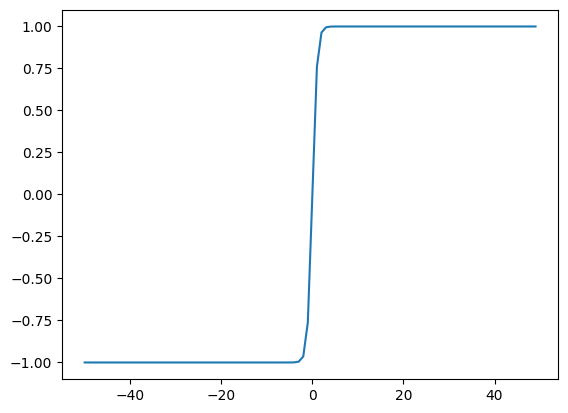

In [22]:
import matplotlib.pyplot as plt
temps = np.arange(-50, 50)

plt.plot(temps, np.tanh(temps))

It pushes values to be between `-1` and `1`.  It also has a very steep slope - it reaches `1` and `-1` very quickly.  The tanh activation function is better for our purposes than sigmoid because it enables us to have negative values.  This is important because it enables the gradient to be steeper as well.

Let's take a look at the derivative of tanh:

In [29]:
from sympy import diff, symbols, exp, expand

x = symbols("x")
sympy_tanh = (exp(x) - exp(-x)) / (exp(x) + exp(-x))
diff(sympy_tanh, x)

(-exp(x) + exp(-x))*(exp(x) - exp(-x))/(exp(x) + exp(-x))**2 + 1

Forward pass

Forward pass works similarly to dense networks

But, we have a for loop to process the sequence, and we send the output of h in 2 directions

## H direction diagram

Show example of doing a forward pass with 3 sequence elements

In the backward pass, we have to pay attention to the gradient

Gradient affects current output value only in the last position

## Show gradient last diagram

But in other positions, the gradient affects the previous hidden state and the output

## Show gradient inside diagram

We have to account for this by adding together both gradients

Show backward pass with 3 sequence elements

Show everything together